In [1]:
# Importing libraries
import pandas as pd
import regex as re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import Dataset
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from langdetect import detect
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from transformers import GPT2Tokenizer, GPT2Model

In [2]:
# Load data
data = pd.read_csv('all_ECB_speeches.csv',sep = '|')

In [3]:
# Remove non-english speeches

# Function to detect language of a given text
def detect_language(text):
    try:
        lang = detect(text)
    except:
        lang = "Unknown"
    return lang

# Apply the language detection function to each text in your DataFrame
data['language'] = data['contents'].apply(detect_language)

# Filter out the texts that are not in English
data = data[data['language'] == 'en']


In [4]:
# Drop null values
data = data.dropna(subset=['speakers','contents'])
# Reset index
data = data.reset_index(drop=True)
# Remove introduction
for row in range (data.shape[0]):
  try:
    speech = re.split(
        " \d+ (January|February|March|April|May|June|July|August|September|October|November|December) \d{4} ",
        data.loc[row, "contents"])
    data.loc[row, "contents"] = speech[-1]
  except:
    pass        

In [5]:
# Split into sentences
sentences_list = []
for row in range (data.shape[0]):
    text = data.loc[row, "contents"]
    sentences = re.split(r'[.!?]', text)
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    sentences_list.append(sentences)
data['sentences'] = sentences_list


In [6]:
# Remove stopwords and punctuation
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
stop_words.update(['also', 'ha'])
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text, re.UNICODE)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

sentences_list = []
for row in range (data.shape[0]):
    sentences = data.loc[row, "sentences"]
    sentences = [preprocess_text(sentence) for sentence in sentences]
    sentences_list.append(sentences)

data['sentences'] = sentences_list


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lavin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lavin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lavin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# Vectorize the data
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['sentences'].apply(lambda x: ' '.join(x)))

In [8]:
def get_top_n_words(corpus, n=10):
        vec = CountVectorizer().fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        return words_freq[:n]

def KMeans_clustering(X,data,num_clusters):
    new_df = data.copy()
# Determine the number of clusters
    # Execute K-means clustering
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X)

    # Get cluster labels for each text
    cluster_labels = kmeans.labels_

    # Add cluster labels to the DataFrame
    new_df['cluster'] = cluster_labels

    # Identify the most frequent words in each cluster
    for i in range(num_clusters):
        print(f"Cluster {i}:")
        corpus = new_df[new_df['cluster'] == i]['sentences'].apply(lambda x: ' '.join(x))
        common_words = get_top_n_words(corpus, 20)
        print(common_words,'\n')
    return new_df

    


In [9]:
data_kmeans_3 = KMeans_clustering(X,data,3)

c:\Users\Lavin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0:
[('policy', 31489), ('euro', 27078), ('monetary', 25288), ('area', 22290), ('rate', 18049), ('inflation', 17072), ('price', 16802), ('economic', 14981), ('market', 14850), ('bank', 13826), ('growth', 12485), ('financial', 11411), ('stability', 11049), ('country', 10943), ('ecb', 10248), ('economy', 10046), ('central', 9428), ('would', 8572), ('european', 7969), ('year', 7460)] 

Cluster 1:
[('bank', 7185), ('euro', 6070), ('payment', 5539), ('european', 4740), ('market', 4706), ('financial', 4693), ('central', 4310), ('area', 3836), ('policy', 3488), ('ecb', 3433), ('would', 3416), ('risk', 3024), ('country', 2827), ('monetary', 2783), ('system', 2614), ('economic', 2598), ('wa', 2455), ('europe', 2371), ('need', 2336), ('new', 2265)] 

Cluster 2:
[('financial', 21623), ('market', 16311), ('bank', 15488), ('risk', 9025), ('euro', 8225), ('policy', 8008), ('area', 8005), ('banking', 6547), ('system', 5748), ('crisis', 5739), ('european', 5598), ('stability', 5407), ('monetary

In [10]:
data_kmeans_4 = KMeans_clustering(X,data,4)


c:\Users\Lavin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0:
[('bank', 6711), ('payment', 5504), ('euro', 5370), ('financial', 4341), ('market', 4322), ('european', 4068), ('central', 3969), ('area', 3325), ('ecb', 3138), ('would', 3131), ('policy', 2878), ('risk', 2868), ('system', 2464), ('monetary', 2360), ('country', 2224), ('wa', 2145), ('economic', 2129), ('need', 2070), ('europe', 2029), ('new', 1984)] 

Cluster 1:
[('financial', 19870), ('market', 14549), ('bank', 14474), ('risk', 8497), ('policy', 6756), ('area', 6402), ('euro', 6383), ('banking', 6085), ('system', 5313), ('stability', 4885), ('crisis', 4753), ('central', 4721), ('european', 4634), ('monetary', 4426), ('liquidity', 4057), ('sector', 3991), ('would', 3825), ('ecb', 3816), ('integration', 3546), ('credit', 3505)] 

Cluster 2:
[('euro', 20512), ('area', 15711), ('policy', 12652), ('country', 10054), ('market', 9915), ('monetary', 9670), ('economic', 9390), ('growth', 8221), ('european', 7285), ('rate', 7155), ('financial', 6844), ('price', 6191), ('stability', 5

In [11]:
# Cluster 0 seems to be about activity
# Cluster 1 seems to be the about monetary policy
# Cluster 2 seems to be about inflation
# Cluster 3 seems to be about economic crisis
# Rename the clusters
data_kmeans_4['cluster'] = data_kmeans_4['cluster'].replace({0: 'activity', 1: 'monetary policy', 2: 'inflation', 3: 'economic crisis'})

In [12]:
data_kmeans_5 = KMeans_clustering(X,data,5)

c:\Users\Lavin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0:
[('payment', 4874), ('bank', 2504), ('euro', 1809), ('market', 1625), ('sepa', 1601), ('service', 1354), ('system', 1299), ('central', 1293), ('european', 1201), ('digital', 1191), ('would', 1151), ('financial', 1138), ('card', 863), ('area', 851), ('money', 824), ('retail', 806), ('new', 671), ('need', 659), ('ecb', 650), ('eurosystem', 638)] 

Cluster 1:
[('bank', 5114), ('euro', 4190), ('financial', 4008), ('european', 3502), ('market', 3499), ('policy', 3437), ('central', 3118), ('area', 3007), ('ecb', 2962), ('risk', 2729), ('monetary', 2635), ('would', 2449), ('economic', 2414), ('country', 2321), ('wa', 2152), ('economy', 1903), ('year', 1805), ('see', 1783), ('one', 1747), ('europe', 1738)] 

Cluster 2:
[('euro', 20420), ('area', 15609), ('policy', 13077), ('monetary', 10199), ('country', 9680), ('market', 9563), ('economic', 9465), ('growth', 8187), ('rate', 7219), ('european', 6942), ('price', 6746), ('financial', 6544), ('stability', 6029), ('economy', 5299), ('wo

In [13]:
# Cluster 0 seems to be about monetary policy
# Cluster 1 seems to be the about inflation
# Cluster 2 seems to be about digital euro
# Cluster 3 seems to be about economic activity
# Cluster 4 seems to be about economic instability


# Gráficos

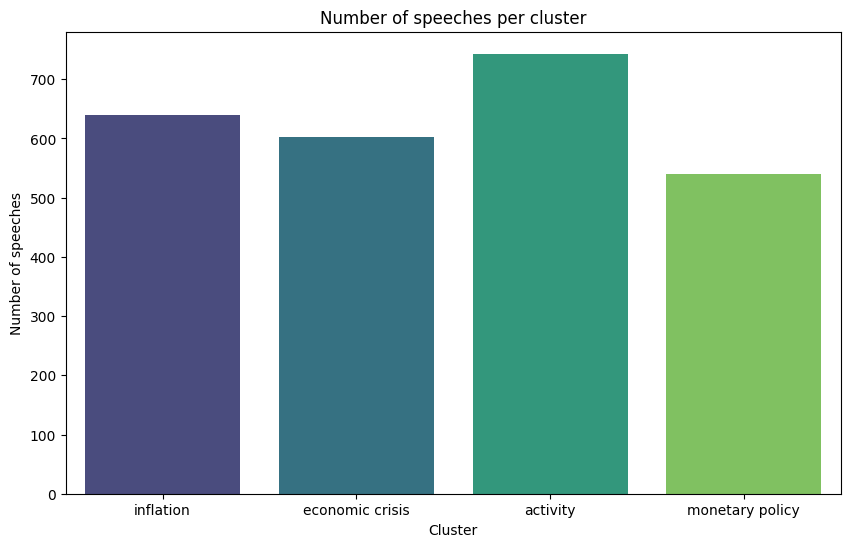

In [14]:
# Histogram of the clusters
plt.figure(figsize=(10, 6))
sns.countplot(data=data_kmeans_4, x='cluster', palette='viridis')
plt.title('Number of speeches per cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of speeches')
plt.show()


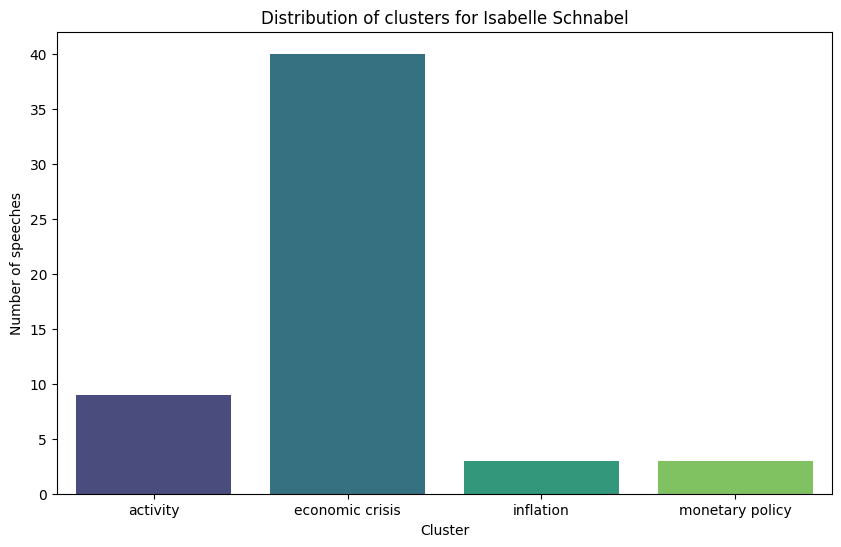

In [15]:
# Plot the distribution of the clusters for speakers in a stacked bar plot

# Use Isabelle Schnabel as an example
example = data_kmeans_4[data_kmeans_4['speakers'] == 'Isabel Schnabel']
example = example.groupby(['speakers', 'cluster']).size().reset_index(name='count')
plt.figure(figsize=(10, 6))
sns.barplot(data=example, x='cluster', y='count', palette='viridis')
plt.title('Distribution of clusters for Isabelle Schnabel')
plt.xlabel('Cluster')
plt.ylabel('Number of speeches')
plt.show()



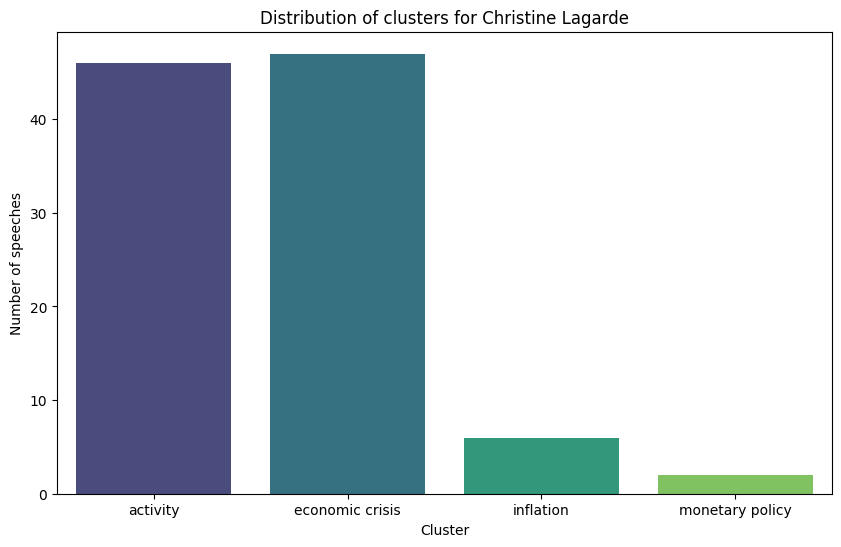

In [16]:
# Plot the distribution of the clusters for speakers in a stacked bar plot

# Use Christine Lagarde as an example
example = data_kmeans_4[data_kmeans_4['speakers'] == 'Christine Lagarde']
example = example.groupby(['speakers', 'cluster']).size().reset_index(name='count')
plt.figure(figsize=(10, 6))
sns.barplot(data=example, x='cluster', y='count', palette='viridis')
plt.title('Distribution of clusters for Christine Lagarde')
plt.xlabel('Cluster')
plt.ylabel('Number of speeches')
plt.show()



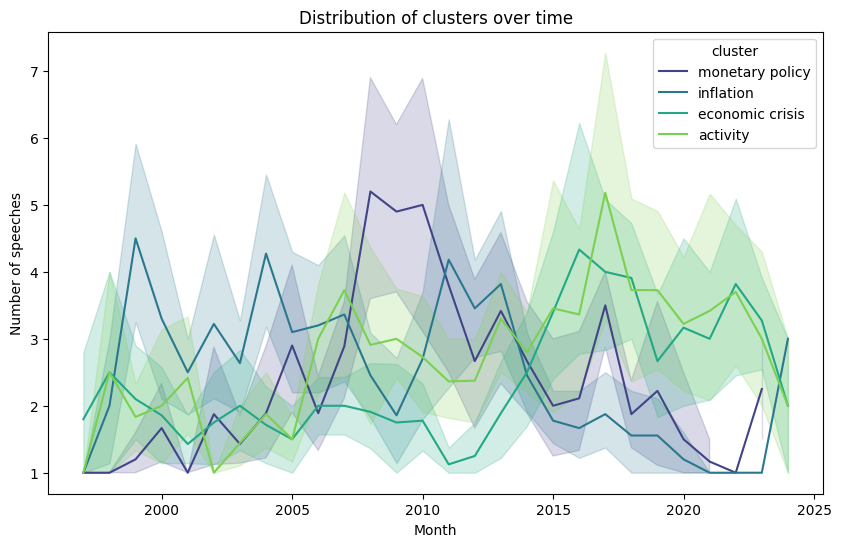

In [17]:
# Line plot of clusters over time per month and year
data_kmeans_4['year'] = pd.to_datetime(data_kmeans_4['date']).dt.year
data_kmeans_4['month'] = pd.to_datetime(data_kmeans_4['date']).dt.month
example = data_kmeans_4.groupby(['year', 'month', 'cluster']).size().reset_index(name='count')
plt.figure(figsize=(10, 6))
sns.lineplot(data=example, x='year', y='count', hue='cluster', palette='viridis')
plt.title('Distribution of clusters over time')
plt.xlabel('Month')
plt.ylabel('Number of speeches')
plt.show()



C:\Users\Lavin\AppData\Local\Temp\ipykernel_34124\1565357728.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example['year'] = example['date'].dt.year
C:\Users\Lavin\AppData\Local\Temp\ipykernel_34124\1565357728.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example['month'] = example['date'].dt.month
C:\Users\Lavin\AppData\Local\Temp\ipykernel_34124\1565357728.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

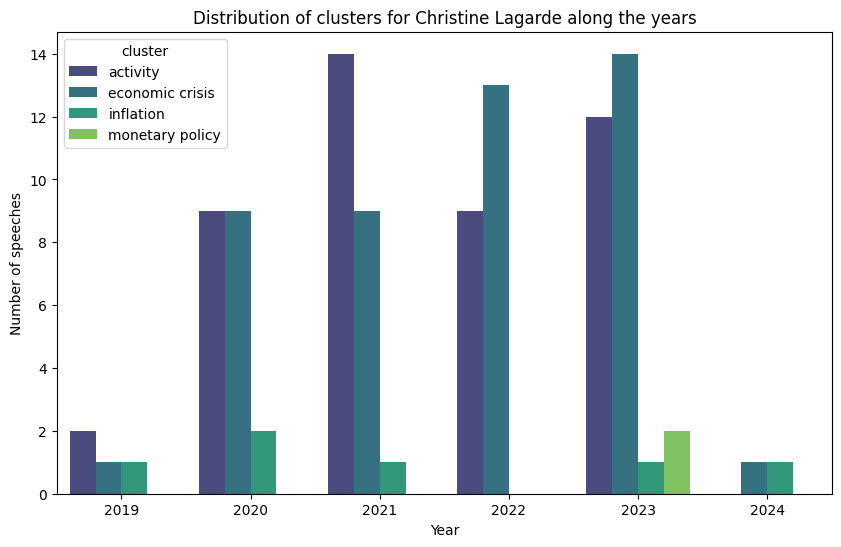

In [18]:
# topics along the years for a specific speaker
# Use Christine Lagarde as an example
data_kmeans_4['date'] = pd.to_datetime(data_kmeans_4['date'])
example = data_kmeans_4[data_kmeans_4['speakers'] == 'Christine Lagarde']
# plot the distribution of the clusters for Christine Lagarde along the trimesters
example['year'] = example['date'].dt.year
example['month'] = example['date'].dt.month
example['trimester'] = example['month'].apply(lambda x: (x-1)//3+1) 
example = example.groupby(['year', 'cluster']).size().reset_index(name='count')
plt.figure(figsize=(10, 6))
sns.barplot(data=example, x='year', y='count', hue='cluster', palette='viridis')
plt.title('Distribution of clusters for Christine Lagarde along the years')
plt.xlabel('Year')
plt.ylabel('Number of speeches')
plt.show()



In [19]:
example

,year,cluster,count
0,2019,activity,2
1,2019,economic crisis,1
2,2019,inflation,1
3,2020,activity,9
4,2020,economic crisis,9
5,2020,inflation,2
6,2021,activity,14
7,2021,economic crisis,9
8,2021,inflation,1
9,2022,activity,9
